## Imports

In [17]:
import json
from transformers import AutoModelForCausalLM, AutoTokenizer
from dataset import CoconutDataset, collate_fn
from config import Config
from model import Coconut
import torch
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
import numpy as np
from time import time

In [18]:
plt.style.use("default")

## Coconut

In [19]:
model = AutoModelForCausalLM.from_pretrained('openai-community/gpt2')
tokenizer = AutoTokenizer.from_pretrained('openai-community/gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_tokens("<|start-latent|>")
tokenizer.add_tokens("<|end-latent|>")
tokenizer.add_tokens("<|latent|>")
latent_id = tokenizer.convert_tokens_to_ids("<|latent|>")
start_id = tokenizer.convert_tokens_to_ids("<|start-latent|>")
end_id = tokenizer.convert_tokens_to_ids("<|end-latent|>")
model.resize_token_embeddings(len(tokenizer))
embeddings = model.get_input_embeddings()
target_id = tokenizer.convert_tokens_to_ids("<<")
for token_id in [latent_id, start_id, end_id]:
    target_embedding = embeddings.weight.data[target_id]
    embeddings.weight.data[token_id] = target_embedding
model = Coconut(model, latent_id, tokenizer.eos_token_id)

model.load_state_dict(torch.load("/users/eleves-b/2021/julien.genzling/LLM-latent-reasoning/models/prosqa/5"))

model.to(Config.device)

Coconut(
  (base_causallm): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50260, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D(nf=2304, nx=768)
            (c_proj): Conv1D(nf=768, nx=768)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=3072, nx=768)
            (c_proj): Conv1D(nf=768, nx=3072)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_featu

In [20]:
dataset_val = CoconutDataset(
        name="prosqa",
        train_or_val="valid",
        modality="coconut",
        stage=5,
        debug = False,
        tokenizer=tokenizer,
        start_id=start_id,
        end_id=end_id,
        latent_id=latent_id,
        c=1,
    )

collate = partial(collate_fn, tokenizer=tokenizer, latent_id=latent_id)
valid_gen_dataloader = torch.utils.data.DataLoader(
    dataset_val,
    num_workers=1,
    pin_memory=True,
    batch_size=1,
    collate_fn=collate,
)

In [21]:
question_val = [
    d["question"] for d in json.load(open(f"data/prosqa_valid.json"))
]
answers_val = [
    d["answer"].replace(",", "").strip()
    for d in json.load(open(f"data/prosqa_valid.json"))
]
cot_val = [
    "\n".join(d["steps"]) for d in json.load(open(f"data/prosqa_valid.json"))
]

In [22]:
correct = torch.tensor(0, device=Config.device)
correct_cot = torch.tensor(0, device=Config.device)
total = torch.tensor(0, device=Config.device)
model.eval()
all_hidden_states = []
generated_tokens = []
times = []
with torch.no_grad():
    for batch in tqdm(valid_gen_dataloader):
        test_idx = batch["idx"][0]

        batch = {
            k: v.to(Config.device)
            for k, v in batch.items()
            if v != None and k not in ["idx", "position_ids"]
        }

        answer = answers_val[test_idx.cpu().item()]
        answer_cot = cot_val[test_idx.cpu().item()]
        question = question_val[test_idx.cpu().item()]

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            start = time()
            outputs, hidden_states = model.generate(**batch, max_new_tokens=128, tokenizer=tokenizer, pad_token_id=tokenizer.eos_token_id)
            end = time()
            all_hidden_states.append(hidden_states)
            generated_tokens.append(outputs.shape[1] - batch["input_ids"].shape[1])
            times.append(end-start)

        text_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
        answer_output = text_output.split("#")[-1].replace(",", "").strip()
        cot_output = ("\n".join(text_output.split("\n")[1:])).split("#")[0].strip()

        correct += answer_output == answer
        correct_cot += cot_output == answer_cot
        total += 1
        
test_accuracy = correct / total
cot_accuracy = correct_cot / total
print(
        f"Validation accuracy: {test_accuracy:.2f} | CoT validation match: {cot_accuracy:.2f}"
    )
print("Mean number of generated tokens : ", np.mean(generated_tokens))
print("Mean time of inference : ", np.mean(times))


  0%|          | 0/300 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 300/300 [00:38<00:00,  7.74it/s]

Validation accuracy: 0.86 | CoT validation match: 0.00
Mean number of generated tokens :  8.22
Mean time of inference :  0.12704384009043376


### Analysis of Latent Variables

Number of hidden states per sample: [3, 4, 4, 4, 4, 5, 3, 3, 4, 4, 4, 4, 4, 4, 5, 4, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 4, 4, 5, 5, 3, 4, 4, 5, 4, 3, 3, 4, 4, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5, 3, 4, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 5, 4, 4, 3, 3, 5, 4, 3, 4, 3, 4, 4, 5, 3, 3, 3, 4, 5, 3, 3, 3, 3, 3, 4, 5, 4, 3, 3, 5, 4, 3, 4, 3, 3, 3, 3, 4, 5, 4, 3, 4, 4, 4, 4, 4, 4, 3, 3, 5, 3, 4, 3, 4, 5, 3, 4, 4, 4, 4, 5, 4, 3, 4, 5, 4, 4, 4, 5, 4, 4, 5, 3, 4, 4, 3, 3, 4, 3, 5, 4, 3, 3, 5, 3, 4, 4, 4, 4, 3, 3, 5, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 3, 5, 4, 4, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 3, 3, 4, 3, 4, 5, 4, 5, 3, 3, 3, 4, 3, 5, 4, 4, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 4, 3, 3, 4, 4, 5, 3, 4, 4, 5, 4, 3, 4, 3, 4, 3, 5, 4, 4, 4, 3, 4, 4, 3, 5, 4, 4, 3, 5, 4, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4, 5, 5, 3, 3, 4, 5, 5, 4, 5, 4, 3, 3, 3, 3, 3, 3, 3, 4, 5, 3, 3, 4, 5, 3, 3, 3, 3, 4, 3, 3, 5, 3, 3, 4, 4, 4, 3, 5, 5, 5, 4, 3]
Flattened hidden states shape: (1119, 768)


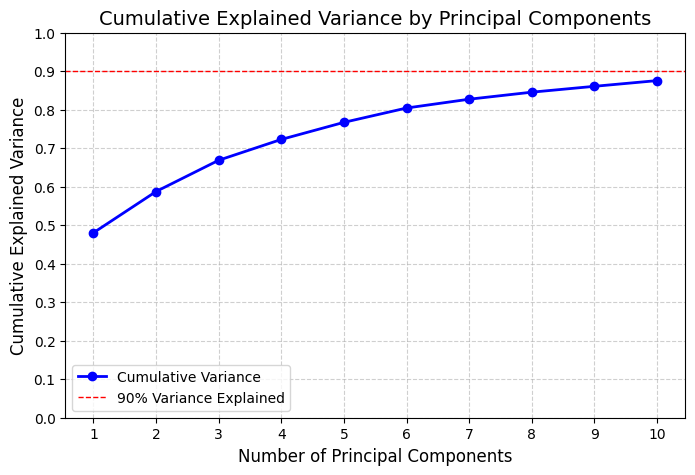

Variance in the first 3 dimensions: 0.6688


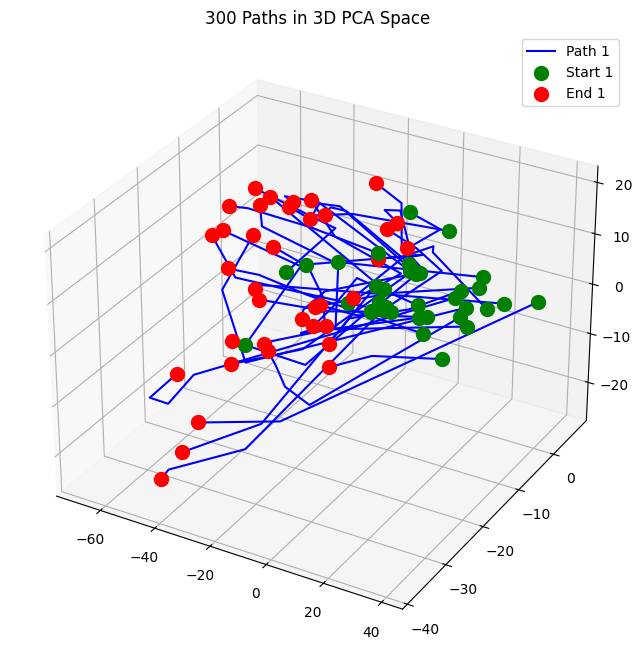

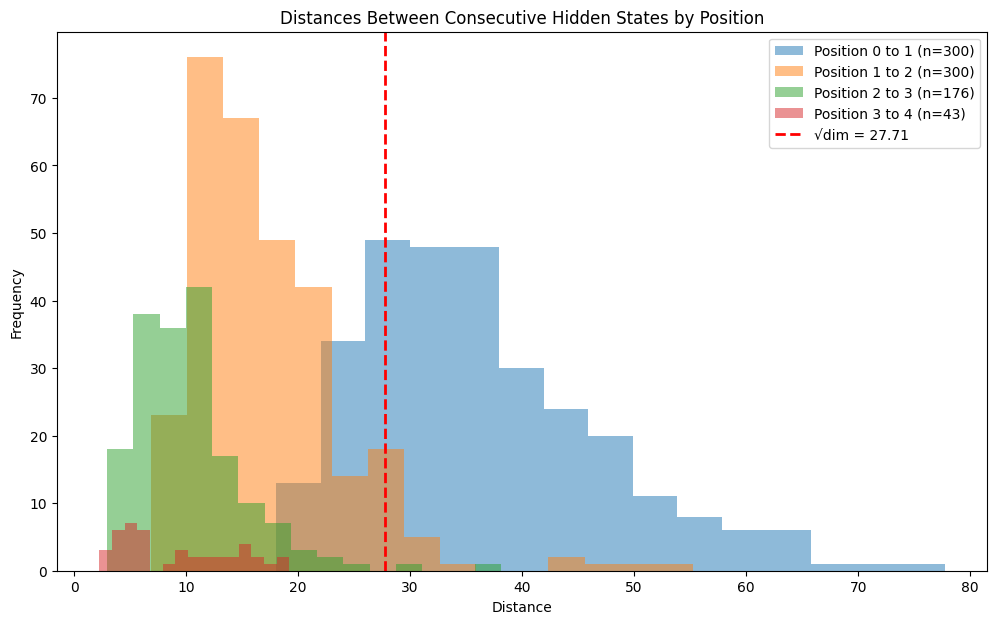


Mean distances by position:
Position 0 to 1: 36.4361 (n=300)
Position 1 to 2: 17.1484 (n=300)
Position 2 to 3: 10.3656 (n=176)
Position 3 to 4: 8.9823 (n=43)


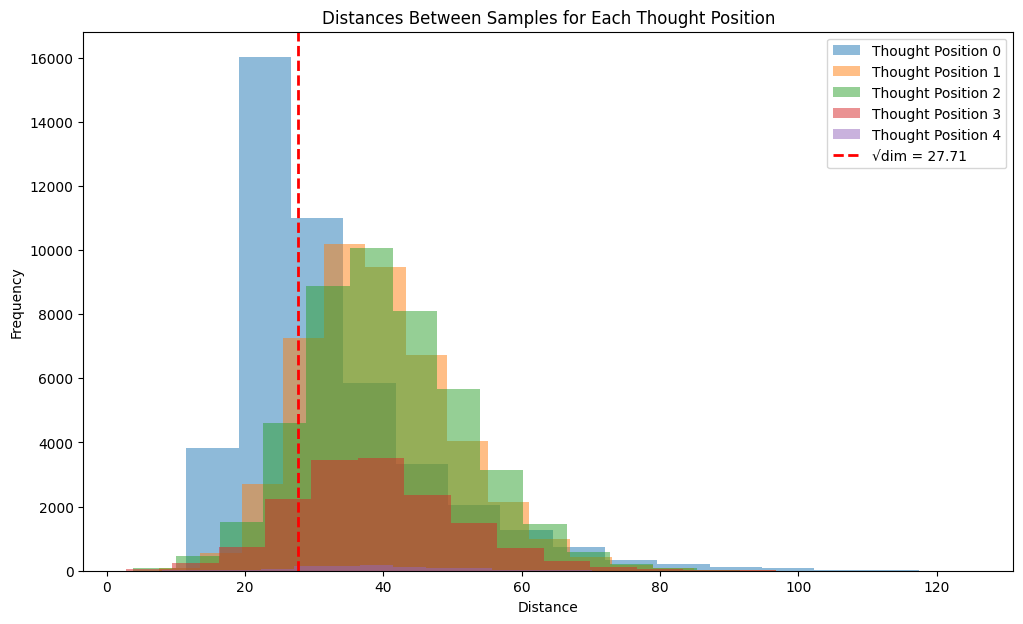


Mean distances between samples by thought position:
Thought Position 0: 32.0022 (n=44850)
Thought Position 1: 39.4835 (n=44850)
Thought Position 2: 40.3328 (n=44850)
Thought Position 3: 39.0008 (n=15400)
Thought Position 4: 38.5163 (n=903)


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import euclidean

# Assuming all_hidden_states is a list of lists, where each inner list contains n hidden states
# First, let's flatten the structure and reshape it properly

# Determine the number of hidden states per sample
num_samples = len(all_hidden_states)
hidden_states_per_sample = [len(h) for h in all_hidden_states]
print(f"Number of hidden states per sample: {hidden_states_per_sample}")

# Flatten the hidden states
flattened_hidden_states = []
for sample_hidden_states in all_hidden_states:
    for hidden_state in sample_hidden_states:
        # Assuming hidden_state is a tensor with shape [1, 768]
        # Convert to numpy and flatten
        flattened_hidden_states.append(hidden_state.squeeze().detach().cpu().numpy())

# Convert to numpy array for easier manipulation
hidden_states_array = np.array(flattened_hidden_states)
print(f"Flattened hidden states shape: {hidden_states_array.shape}")

# Compute PCA on the flattened hidden states
eigenvalues, O = np.linalg.eigh(np.cov(hidden_states_array.T))

# Sort eigenvalues in descending order
eigenvalues = eigenvalues[::-1]
O = O[:, ::-1]  # Eigenvectors corresponding to sorted eigenvalues

# Calculate cumulative explained variance
cumulative_variance = eigenvalues.cumsum() / eigenvalues.sum()

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), cumulative_variance[:10], marker='o', linestyle='-', color='b', lw=2, label="Cumulative Variance")
plt.axhline(y=0.9, color='r', linestyle='dashed', linewidth=1, label="90% Variance Explained")
plt.xlabel("Number of Principal Components", fontsize=12)
plt.ylabel("Cumulative Explained Variance", fontsize=12)
plt.title("Cumulative Explained Variance by Principal Components", fontsize=14)
plt.xticks(range(1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(f'Variance in the first 3 dimensions: {cumulative_variance[2]:.4f}')

# Project the hidden states onto the first 3 principal components
pca_projection = O[:, :3].T @ hidden_states_array.T

# 3D Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot paths for each sample
path_color = 'b'
start_idx = 0

for i in range(num_samples // 8):
    num_states = hidden_states_per_sample[i]
    end_idx = start_idx + num_states
    
    # Extract the 3D coordinates for this sample's path
    x = pca_projection[0, start_idx:end_idx]
    y = pca_projection[1, start_idx:end_idx]
    z = pca_projection[2, start_idx:end_idx]
    
    # Plot the path
    ax.plot(x, y, z, linestyle='-', color=path_color, label=f"Path {i+1}" if i == 0 else "")
    
    # Mark start and end points
    ax.scatter(x[0], y[0], z[0], color='g', s=100, marker='o', label=f"Start {i+1}" if i == 0 else "")
    ax.scatter(x[-1], y[-1], z[-1], color='r', s=100, marker='o', label=f"End {i+1}" if i == 0 else "")
    
    start_idx = end_idx

ax.set_title(f"{num_samples} Paths in 3D PCA Space")
ax.legend()
plt.show()

# If you want to analyze distances by position in the sequence (e.g., start->middle vs middle->end)
# This assumes all samples have the same number of hidden states (e.g., 2)
# Calculate distances by position across all samples, even if they have different numbers of states
# Find the maximum number of states in any sample
max_states = max(hidden_states_per_sample)

if max_states > 1:
    # Initialize a list of lists to store distances for each position
    # We'll have max_states-1 possible transitions
    distances_by_position = [[] for _ in range(max_states - 1)]
    
    start_idx = 0
    for i in range(num_samples):
        num_states = hidden_states_per_sample[i]
        
        # Extract hidden states for this sample
        sample_states = hidden_states_array[start_idx:start_idx + num_states]
        
        # Calculate distances between consecutive states for this sample
        for j in range(num_states - 1):
            dist = euclidean(sample_states[j], sample_states[j+1])
            distances_by_position[j].append(dist)
            
        start_idx += num_states
    
    # Plot histograms for each position that has data
    plt.figure(figsize=(12, 7))
    
    for i, distances in enumerate(distances_by_position):
        if len(distances) > 0:  # Only plot if we have data for this position
            plt.hist(distances, bins=15, alpha=0.5, density=True, label=f'Position {i} to {i+1} (n={len(distances)})')
    
    plt.axvline(sqrt_dim, color='red', linestyle='dashed', linewidth=2, label=f"√dim = {sqrt_dim:.2f}")
    plt.title("Distances Between Consecutive Hidden States by Position")
    plt.xlabel("Distance")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
    # Also print the mean distance for each position
    print("\nMean distances by position:")
    for i, distances in enumerate(distances_by_position):
        if len(distances) > 0:
            print(f"Position {i} to {i+1}: {np.mean(distances):.4f} (n={len(distances)})")

# MODIFIED SECTION: Calculate distances between the nth thought across different samples

# First, reorganize the hidden states into a matrix where each row is a sample
# and each column is a thought position
hidden_states_by_position = []
max_states = max(hidden_states_per_sample)

# Initialize a list of lists to store hidden states for each position
# We'll have max_states possible positions (0 to max_states-1)
states_by_position = [[] for _ in range(max_states)]

start_idx = 0
for i in range(num_samples):
    num_states = hidden_states_per_sample[i]
    end_idx = start_idx + num_states
    
    # Extract hidden states for this sample
    sample_states = hidden_states_array[start_idx:start_idx + num_states]
    
    # Add each state to the appropriate position list
    for j in range(num_states):
        states_by_position[j].append(sample_states[j])
    
    start_idx += num_states

# Calculate distances between all pairs of samples for each thought position
distances_across_samples_by_position = []

for pos in range(max_states):
    pos_states = states_by_position[pos]
    if len(pos_states) > 1:  # Only compute if we have more than one sample
        distances = []
        for i in range(len(pos_states)):
            for j in range(i+1, len(pos_states)):
                dist = euclidean(pos_states[i], pos_states[j])
                distances.append(dist)
        distances_across_samples_by_position.append(distances)

# Plot histograms for distances between samples at each thought position
plt.figure(figsize=(12, 7))

for i, distances in enumerate(distances_across_samples_by_position):
    if len(distances) > 0:  # Only plot if we have data for this position
        plt.hist(distances, bins=15, alpha=0.5, density=True, label=f'Thought Position {i}')

plt.axvline(sqrt_dim, color='red', linestyle='dashed', linewidth=2, label=f"√dim = {sqrt_dim:.2f}")
plt.title("Distances Between Samples for Each Thought Position")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Print the mean distance for each position
print("\nMean distances between samples by thought position:")
for i, distances in enumerate(distances_across_samples_by_position):
    if len(distances) > 0:
        print(f"Thought Position {i}: {np.mean(distances):.4f} (n={len(distances)})")

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import euclidean


df = pd.DataFrame(all_hidden_states)



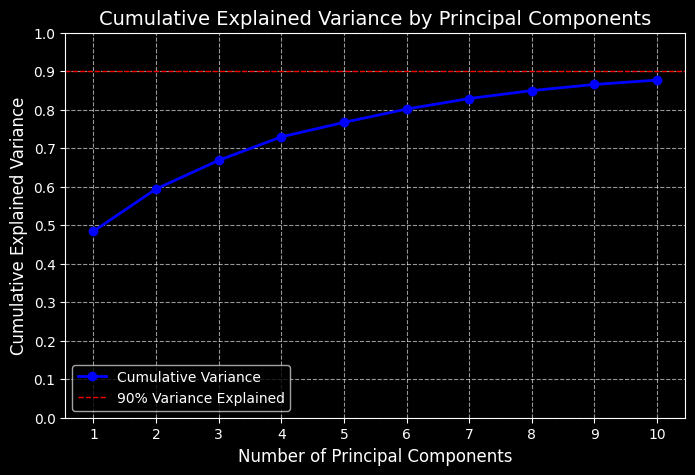

In [36]:

eigenvalues, O = np.linalg.eigh(df.cov())

eigenvalues = eigenvalues[::-1]

cumulative_variance = eigenvalues.cumsum() / eigenvalues.sum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), cumulative_variance[:10], marker='o', linestyle='-', color='b', lw=2, label="Cumulative Variance")

plt.axhline(y=0.9, color='r', linestyle='dashed', linewidth=1, label="90% Variance Explained")

plt.xlabel("Number of Principal Components", fontsize=12)
plt.ylabel("Cumulative Explained Variance", fontsize=12)
plt.title("Cumulative Explained Variance by Principal Components", fontsize=14)
plt.xticks(range(1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


In [37]:
print('Variance in the first 3 dimensions ',(eigenvalues.cumsum()/eigenvalues.sum())[2])

Variance in the first 3 dimensions  0.6685650922816047


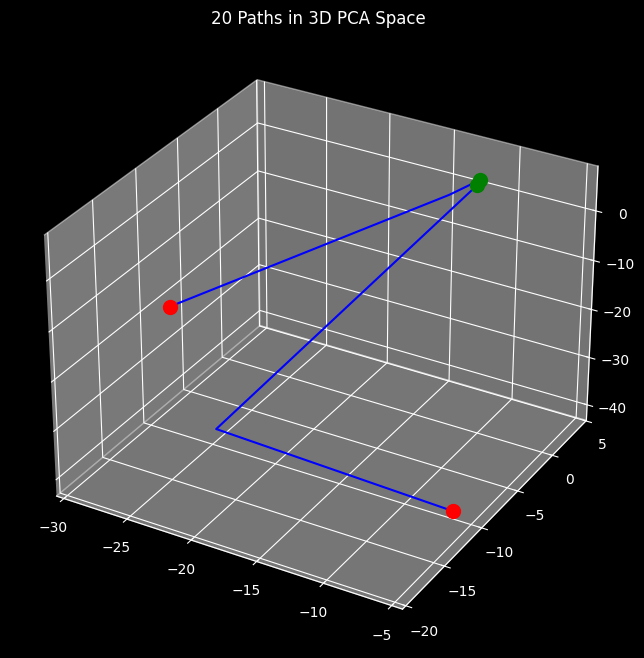

In [38]:



fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

path_color = 'b'  

for i in range(2):
    X_pca_3 = (pd.DataFrame(O).iloc[:, -3:].T @ df.T).iloc[:, 3*i:3*i+3].values

    x, y, z = X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2]

    ax.plot(x, y, z, linestyle='-', color=path_color, label=f"Path {i+1}" if i == 0 else "")

    ax.scatter(x[0], y[0], z[0], color='g', s=100, marker='o', label=f"Start {i+1}" if i == 0 else "")
    ax.scatter(x[-1], y[-1], z[-1], color='r', s=100, marker='o', label=f"End {i+1}" if i == 0 else "")


ax.set_title("20 Paths in 3D PCA Space")

plt.show()


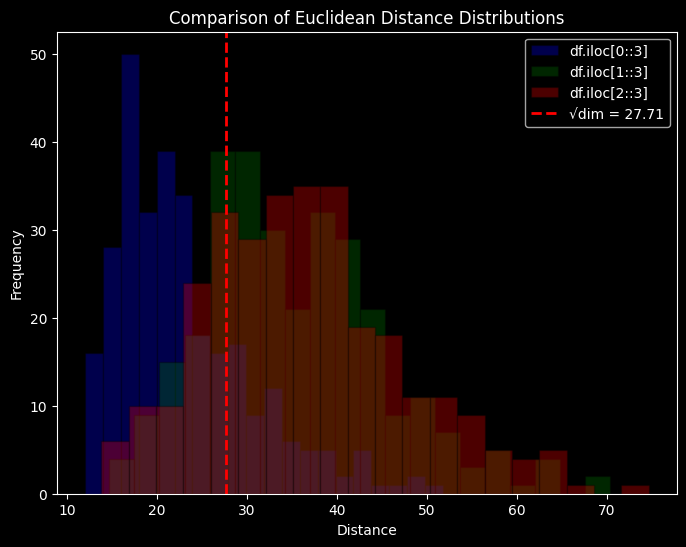

In [39]:

def compute_distances(df_subset):
    distances = []
    for i in range(len(df_subset) - 1):
        dist = euclidean(df_subset.iloc[i], df_subset.iloc[i+1])
        distances.append(dist)
    return distances

distances_0 = compute_distances(df.iloc[0::3])
distances_1 = compute_distances(df.iloc[1::3])
distances_2 = compute_distances(df.iloc[2::3])

sqrt_dim = np.sqrt(df.shape[1])

plt.figure(figsize=(8,6))

plt.hist(distances_0, bins=20, alpha=0.3, color='blue', edgecolor='black', label='df.iloc[0::3]')
plt.hist(distances_1, bins=20, alpha=0.3, color='green', edgecolor='black', label='df.iloc[1::3]')
plt.hist(distances_2, bins=20, alpha=0.3, color='red', edgecolor='black', label='df.iloc[2::3]')

plt.axvline(sqrt_dim, color='red', linestyle='dashed', linewidth=2, label=f"√dim = {sqrt_dim:.2f}")

plt.title("Comparison of Euclidean Distance Distributions")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.legend()
plt.show()


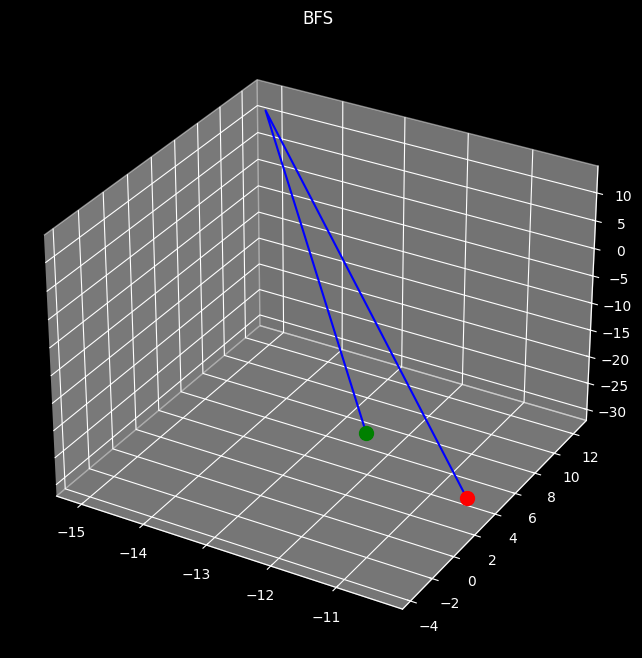

In [40]:



fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

path_color = 'b'  
X_pca_3 = (pd.DataFrame(O).iloc[:, -3:].T @ df.T).iloc[:, 3*2:3*2+3].values
x, y, z = X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2]

ax.plot(x, y, z, linestyle='-', color=path_color, label=f"Path {i+1}" if i == 0 else "")

ax.scatter(x[0], y[0], z[0], color='g', s=100, marker='o', label=f"Start {i+1}" if i == 0 else "")
ax.scatter(x[-1], y[-1], z[-1], color='r', s=100, marker='o', label=f"End {i+1}" if i == 0 else "")


ax.set_title("BFS")

plt.show()

## COT

In [41]:
model = AutoModelForCausalLM.from_pretrained('openai-community/gpt2')
tokenizer = AutoTokenizer.from_pretrained('openai-community/gpt2')
tokenizer.pad_token = tokenizer.eos_token

latent_id = tokenizer.convert_tokens_to_ids("<|latent|>")
start_id = tokenizer.convert_tokens_to_ids("<|start-latent|>")
end_id = tokenizer.convert_tokens_to_ids("<|end-latent|>")

model.load_state_dict(torch.load("/users/eleves-b/2021/julien.genzling/best-prosqa-cot"))

model.to(Config.device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [42]:
dataset_val = CoconutDataset(
        name="prosqa",
        train_or_val="valid",
        modality="coconut",
        stage=3,
        debug = False,
        tokenizer=tokenizer,
        start_id=start_id,
        end_id=end_id,
        latent_id=latent_id,
        c=1,
    )

collate = partial(collate_fn, tokenizer=tokenizer, latent_id=latent_id)
valid_gen_dataloader = torch.utils.data.DataLoader(
    dataset_val,
    num_workers=1,
    pin_memory=True,
    batch_size=1,
    collate_fn=collate,
)

In [43]:
question_val = [
    d["question"] for d in json.load(open(f"data/prosqa_valid.json"))
]
answers_val = [
    d["answer"].replace(",", "").strip()
    for d in json.load(open(f"data/prosqa_valid.json"))
]
cot_val = [
    "\n".join(d["steps"]) for d in json.load(open(f"data/prosqa_valid.json"))
]

In [44]:
correct = torch.tensor(0, device=Config.device)
correct_cot = torch.tensor(0, device=Config.device)
total = torch.tensor(0, device=Config.device)
model.eval()
all_hidden_states = []
generated_tokens = []
times = []
with torch.no_grad():
    for batch in tqdm(valid_gen_dataloader):
        test_idx = batch["idx"][0]

        batch = {
            k: v.to(Config.device)
            for k, v in batch.items()
            if v != None and k not in ["idx", "position_ids"]
        }

        answer = answers_val[test_idx.cpu().item()]
        answer_cot = cot_val[test_idx.cpu().item()]
        question = question_val[test_idx.cpu().item()]

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            start = time()
            outputs = model.generate(**batch, max_new_tokens=128, tokenizer=tokenizer, pad_token_id=tokenizer.eos_token_id)
            end = time()
            generated_tokens.append(outputs.shape[1] - batch["input_ids"].shape[1])
            times.append(end-start)

        text_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
        answer_output = text_output.split("#")[-1].replace(",", "").strip()
        cot_output = ("\n".join(text_output.split("\n")[1:])).split("#")[0].strip()

        correct += answer_output == answer
        correct_cot += cot_output == answer_cot
        total += 1
        
test_accuracy = correct / total
cot_accuracy = correct_cot / total
print(
        f"Validation accuracy: {test_accuracy:.2f} | CoT validation match: {cot_accuracy:.2f}"
    )
print("Mean number of generated tokens : ", np.mean(generated_tokens))
print("Mean time of inference : ", np.mean(times))


  0%|          | 0/300 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 300/300 [02:11<00:00,  2.28it/s]

Validation accuracy: 0.81 | CoT validation match: 0.44
Mean number of generated tokens :  51.013333333333335
Mean time of inference :  0.4368441478411357
